In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=5fc92ae6a099ce31a26c77daf66ade60535ee0360196408531abb7da974e9167
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=8930c386d79069eb846bbb50295632cd55c0f3093d30015d3f040349ddca2eb4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12942/12942), 27.68 MiB | 10.09 MiB/s, done.
Updating files: 100% (12939/12939), done.


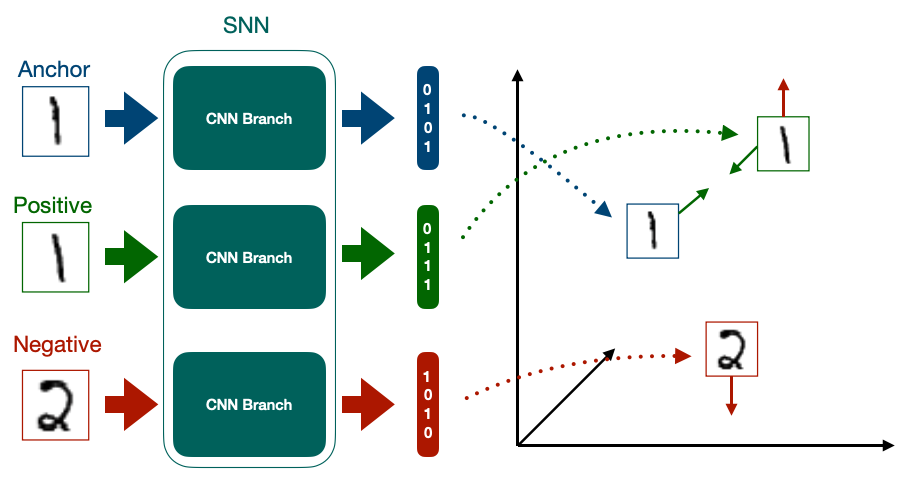

# Imports

In [ ]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [ ]:
DATA_DIR = "/content/Person-Re-Id-Dataset/train/"
CSV_FILE = "/content/Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = "cuda"

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

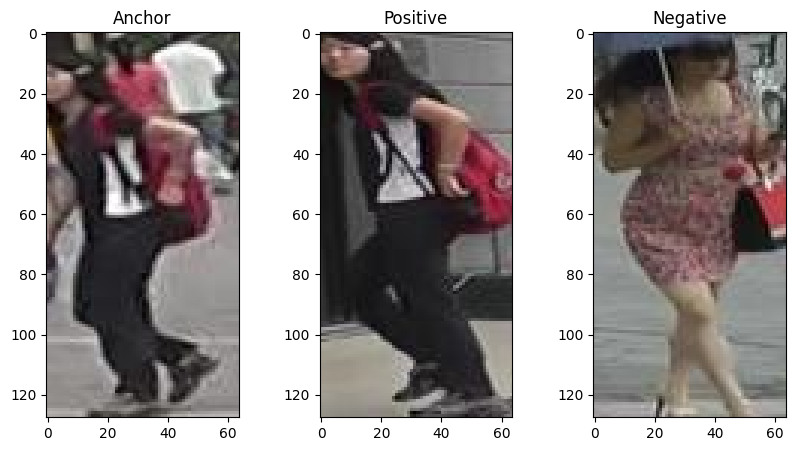

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Create APN Dataset

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self,df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img


In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 3200
Size of validset: 800


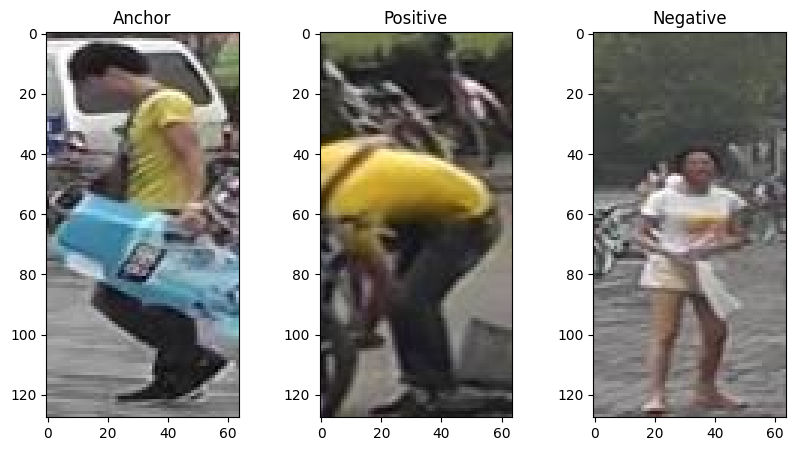

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)

    return embeddings

In [ ]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #Turns on dropout
  total_loss = 0.0

  for A,P,N in tqdm(dataloader):

    A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):
  model.eval() #Turns off dropout
  total_loss = 0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):

      A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("Saved Weights successfully")

  print(f"EPOCHS: {i+1} | train_loss: {train_loss} | valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


Saved Weights successfully
EPOCHS: 1 | train_loss: 0.6058309826254845 | valid_loss : 0.44052494287490845


100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


Saved Weights successfully
EPOCHS: 2 | train_loss: 0.28285052210092543 | valid_loss : 0.24629564881324767


100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


Saved Weights successfully
EPOCHS: 3 | train_loss: 0.1344274351745844 | valid_loss : 0.2382847958803177


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Saved Weights successfully
EPOCHS: 4 | train_loss: 0.1336745348572731 | valid_loss : 0.2177681213617325


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Saved Weights successfully
EPOCHS: 5 | train_loss: 0.09325970575213433 | valid_loss : 0.1670023214817047


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Saved Weights successfully
EPOCHS: 6 | train_loss: 0.05186439290642739 | valid_loss : 0.13388621151447297


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


EPOCHS: 7 | train_loss: 0.0465994393825531 | valid_loss : 0.1521754288673401


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


EPOCHS: 8 | train_loss: 0.06253923922777176 | valid_loss : 0.15700168251991273


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Saved Weights successfully
EPOCHS: 9 | train_loss: 0.06447374179959298 | valid_loss : 0.11704957365989685


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


EPOCHS: 10 | train_loss: 0.027168917655944824 | valid_loss : 0.12452542424201965


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


EPOCHS: 11 | train_loss: 0.032191217392683026 | valid_loss : 0.17598391950130463


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


EPOCHS: 12 | train_loss: 0.06174406260251999 | valid_loss : 0.18098081648349762


100%|██████████| 25/25 [00:04<00:00,  5.57it/s]


EPOCHS: 13 | train_loss: 0.04816805809736252 | valid_loss : 0.13202465891838075


100%|██████████| 25/25 [00:03<00:00,  7.93it/s]


EPOCHS: 14 | train_loss: 0.03752768941223621 | valid_loss : 0.17443593561649323


100%|██████████| 25/25 [00:03<00:00,  7.88it/s]


Saved Weights successfully
EPOCHS: 15 | train_loss: 0.034683648198843 | valid_loss : 0.10484932959079743


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis=1)

  return df_enc



In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df["Anchor"])

<ipython-input-31-1b363da23504>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████████| 4000/4000 [00:46<00:00, 

In [ ]:
df_enc.to_csv("database.csv", index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.506932,0.141557,0.459294,0.291795,0.722100,0.129970,0.213314,0.253692,0.256903,...,0.165949,-0.894419,-0.217436,-0.018073,-0.351814,0.648821,0.088557,0.173143,-0.593548,0.070643
1,1420_c3s3_061978_03.jpg,-0.379349,0.373752,0.179003,0.227001,0.628063,-0.288923,-0.070452,-0.563904,-0.158173,...,0.427332,-0.485090,-0.420259,-0.071892,-0.389997,0.406477,-0.177207,-0.003970,-0.166771,-0.178389
2,1420_c5s3_062565_05.jpg,-0.406823,-0.016858,0.061028,0.459037,0.125544,0.089467,0.116067,-0.380241,0.293297,...,0.315374,-0.507173,-0.181143,0.038941,-0.432281,0.612475,0.055632,-0.304801,0.116603,0.276267
3,1420_c6s3_085592_04.jpg,-0.344114,0.102193,-0.306392,0.198703,0.633571,0.020117,0.059106,0.469558,0.030922,...,0.428571,-0.805930,-0.391766,0.001520,-0.459568,0.831845,0.054568,0.486021,-0.435371,0.259475
4,0663_c5s3_085987_03.jpg,0.325698,-0.816697,0.144472,-1.220461,0.286757,0.050462,0.434889,0.869441,-0.378293,...,-0.077962,0.758913,-0.409605,0.235558,0.239831,-0.007802,0.424053,0.907961,-0.111100,0.316155


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[: , 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


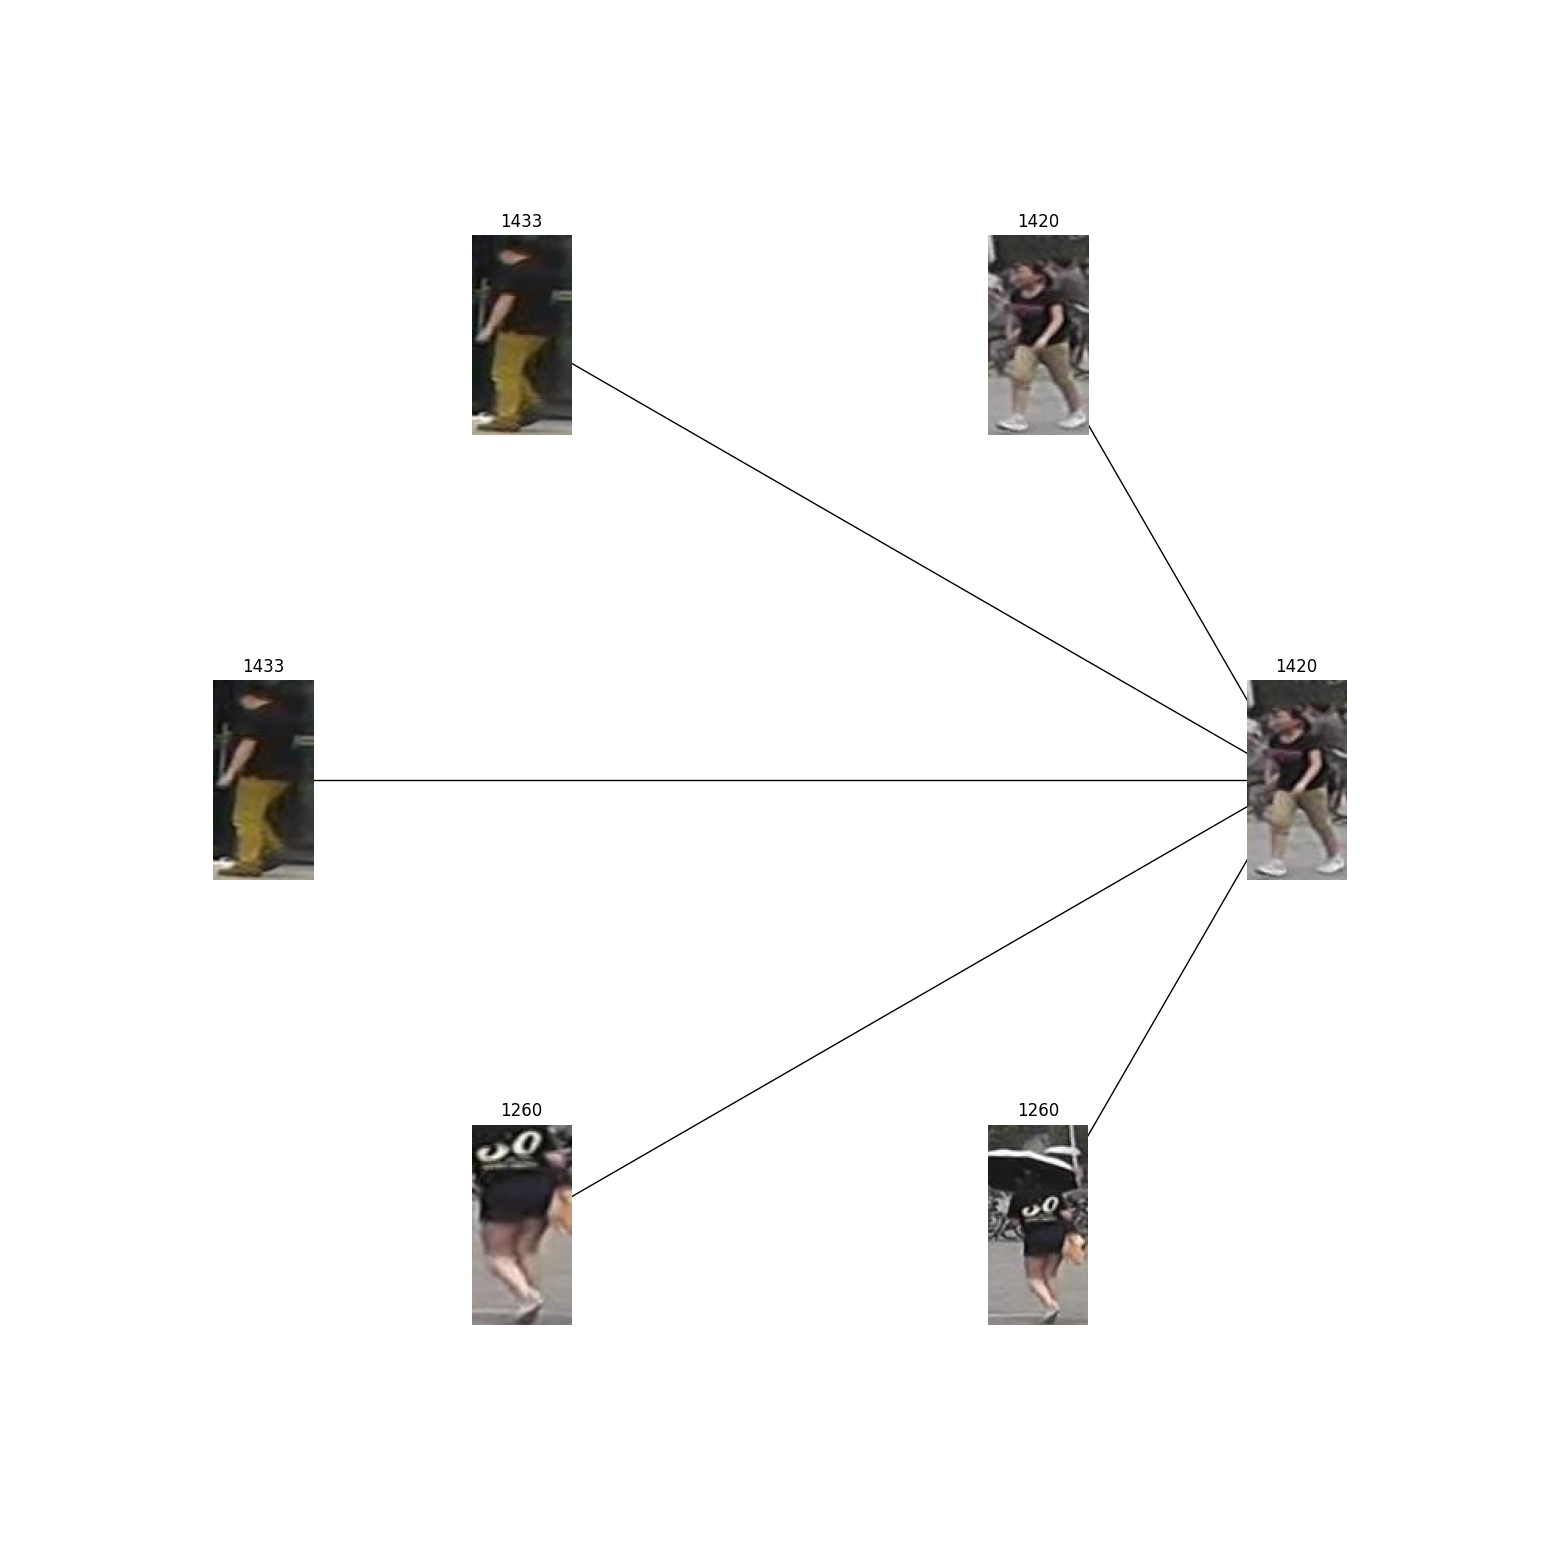

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);